# **Importing Necessary Libraries, Data loading and Preprocessing**

In [ ]:
#importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

#Data Loading and Preprocessing.
# Load the CSV file into selected_df DataFrame
selected_df = pd.read_csv('/content/processed.csv')

# Selecting features and target
features = selected_df[['Latitude', 'Longitude', 'Glacier Form', 'Mean Elevation', 'Minimum Elevation',
                 'Maximum Elevation', 'Average_temp', 'Mean Width', 'Mean Length', 'Maximum Length',
                 'Topographic Map Year']]
target = selected_df['Glacier Area']  # Assuming the goal is to predict the Average Temperature

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Feature Scaling
# Normalizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Extracting mean and standard deviation for later use
mean_features = scaler.mean_  # Mean of each feature
std_features = scaler.scale_  # Standard deviation of each feature

# Data Loading for PyTorch
# Converting to PyTorch tensors
train_features = torch.tensor(X_train_scaled, dtype=torch.float32)
test_features = torch.tensor(X_test_scaled, dtype=torch.float32)
train_targets = torch.tensor(y_train.values, dtype=torch.float32)
test_targets = torch.tensor(y_test.values, dtype=torch.float32)

# Creating datasets and dataloaders
train_dataset = TensorDataset(train_features, train_targets)
test_dataset = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# **Model Definition**

In [ ]:
# Neural Network Model Definition
class GlacierModel(nn.Module):
    def __init__(self):
        super(GlacierModel, self).__init__()
        self.linear1 = nn.Linear(11, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout to reduce overfitting
        self.linear2 = nn.Linear(128, 64)
        self.batchnorm = nn.BatchNorm1d(64)  # Batch normalization to improve training stability
        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.batchnorm(x)
        x = self.output(x)
        return x


# **Initialize the model, criterion, and optimizer**

In [ ]:
# Initializing the model
model = GlacierModel()
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.005) #adam optimizer

# **Define the training function**

In [1]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model.train()
    training_losses = []
    validation_losses = []
    for epoch in range(num_epochs):
        train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Evaluate model on the test set and calculate validation loss
        model.eval()  # Switch to evaluation mode
        with torch.no_grad():
            val_loss = 0
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
                val_loss += loss.item()

        # Average validation loss for this epoch
        avg_val_loss = val_loss / len(test_loader)
        validation_losses.append(avg_val_loss)

          # Print training progress
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        model.train()  # Switch back to training mode

    return training_losses, validation_losses



# **Train the model and get the training and validation losses**

In [ ]:
# Train the model and get the training and validation losses
# Training the model for 1000 epochs
training_losses, validation_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=1000)

Epoch 1/1000, Training Loss: 73.4422, Validation Loss: 24.0911
Epoch 2/1000, Training Loss: 53.1390, Validation Loss: 18.4240
Epoch 3/1000, Training Loss: 42.9719, Validation Loss: 15.3484
Epoch 4/1000, Training Loss: 39.0016, Validation Loss: 10.0049
Epoch 5/1000, Training Loss: 34.9045, Validation Loss: 18.8516
Epoch 6/1000, Training Loss: 33.2922, Validation Loss: 8.0154
Epoch 7/1000, Training Loss: 32.2776, Validation Loss: 8.6945
Epoch 8/1000, Training Loss: 28.7642, Validation Loss: 8.6139
Epoch 9/1000, Training Loss: 26.0519, Validation Loss: 9.2425
Epoch 10/1000, Training Loss: 25.2748, Validation Loss: 13.9626
Epoch 11/1000, Training Loss: 23.3820, Validation Loss: 14.0770
Epoch 12/1000, Training Loss: 26.2711, Validation Loss: 13.0592
Epoch 13/1000, Training Loss: 24.6660, Validation Loss: 29.6491
Epoch 14/1000, Training Loss: 24.0937, Validation Loss: 16.4817
Epoch 15/1000, Training Loss: 25.6765, Validation Loss: 15.0746
Epoch 16/1000, Training Loss: 19.8855, Validation Los

# **Plotting Training and Validation Losses**

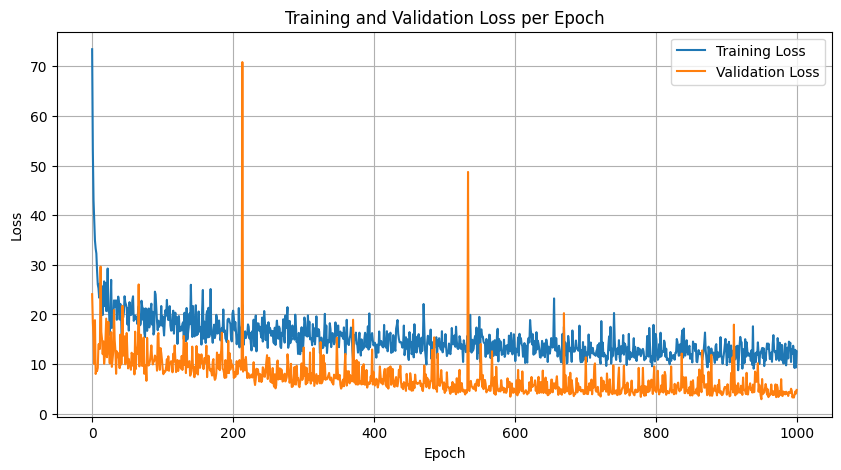

In [ ]:
# Loss Visualization
import matplotlib.pyplot as plt

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# **Model Evaluation and Visualization**

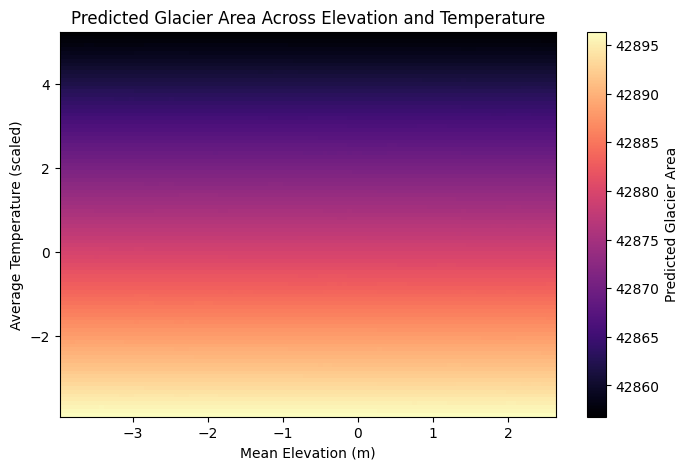

In [ ]:
# Advanced Visualization for Glacier Area Prediction
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming `model`, `scaler.mean_`, `scaler.scale_`, `features`, and `features.columns` are defined from the previous context
# and the `model` has been trained with the standard training loop

def generate_meshgrid_data(x_range, y_range, grid_size, feature_indices, mean_features, std_features):
    x = np.linspace(x_range[0], x_range[1], grid_size)
    y = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(x, y)
    grid = np.vstack([X.ravel(), Y.ravel()]).T
    grid_scaled = (grid - mean_features[feature_indices]) / std_features[feature_indices]
    full_features = np.tile(mean_features, (grid_size**2, 1))
    full_features[:, feature_indices] = grid_scaled
    grid_tensor = torch.tensor(full_features, dtype=torch.float32)
    return X, Y, grid_tensor

def evaluate_model_on_grid(model, grid_tensor):
    model.eval()
    with torch.no_grad():
        predictions = model(grid_tensor).numpy()
    return predictions.reshape(grid_size, grid_size)

# Defining the elevation and temperature indices
elevation_index = features.columns.get_loc('Mean Elevation')
temp_index = features.columns.get_loc('Average_temp')
feature_indices = [elevation_index, temp_index]

# Defining the ranges for the meshgrid based on the normalized features
x_range = [X_train_scaled[:, elevation_index].min(), X_train_scaled[:, elevation_index].max()]
y_range = [X_train_scaled[:, temp_index].min(), X_train_scaled[:, temp_index].max()]
grid_size = 100

# Generate the meshgrid data and evaluate the model
X, Y, grid_tensor = generate_meshgrid_data(x_range, y_range, grid_size, feature_indices, mean_features, std_features)
S = evaluate_model_on_grid(model, grid_tensor)

# Plotting the results
plt.figure(figsize=(8, 5))
contour_plot = plt.pcolormesh(X, Y, S, shading='auto', cmap='magma')
plt.colorbar(contour_plot, label='Predicted Glacier Area')
plt.xlabel('Mean Elevation (m)')
plt.ylabel('Average Temperature (scaled)')
plt.title('Predicted Glacier Area Across Elevation and Temperature')
plt.show()
